In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
data_in_path = '/glade/u/home/zcleveland/scratch/ERA5/dsw/'  # path to subset data
my_corr_path = '/glade/u/home/zcleveland/scratch/ERA5/correlations/'  # path to my correlation datasets
cp_in_path = '/glade/u/home/zcleveland/scratch/ERA5/cp/'  # path to subset CP data
sub_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/subsetting/'  # path to subsetting scripts
plot_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/plotting/'  # path to plotting scripts
fig_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated figures
temp_scratch_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/temp/'  # path to temp directory in scratch

In [3]:
# define list of variables
var_list = [
    # 'lsp',  # large scale precipitation (m of water) - accumu
    # 'cp',  # convective precipitation (m of water) - accumu
    'tp',  # total precipitation (m of water) - accumu -- DERIVED
    'sd',  # snow depth  (m of water equivalent) - instan
    'msl',  # mean sea level pressure (Pa) - instan
    'tcc',  # total cloud cover (0-1) - instan
    'stl1',  # soil temp layer 1 (K) - instan
    'stl2',  # soil temp layer 2 (K) - instan
    'stl3',  # soil temp layer 3 (K) - instan
    'stl4',  # soil temp layer 4 (K) - instan
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3) - instan
    'swvl2',  # soil volume water content layer 2 (m^3 m^-3) - instan
    'swvl3',  # soil volume water content layer 3 (m^3 m^-3) - instan
    'swvl4',  # soil volume water content layer 4 (m^3 m^-3) - instan
    '2t',  # 2 meter temp (K) - instan
    '2d',  # 2 meter dew point (K) - instan
    'ishf',  # instant surface heat flux (W m^-2) - instan
    'ie',  # instant moisture flux (kg m^-2 s^-1) - instan
    'sshf',  # surface sensible heat flux (J m^-2) - accumu
    'slhf',  # surface latent heat flux (J m^-2) - accumu
    'ssr',  # surface net solar radiation (J m^-2) - accumu
    'str',  # surface net thermal radiation (J m^-2) - accumu
    'sro',  # surface runoff (m) - accumu
    'sf',  # total snowfall (m of water equivalent) - accumu
    'cape',  # convective available potential energy (J kg^-1) - instan
    # 'tcw',  # total column water (kg m^-2) - sfc (sum total of solid, liquid, and vapor in a column)
    'ssrd',  # surface solar radiation downwards (J m^-2) - accumu
    'strd',  # surface thermal radiation downwards (J m^-2) - accumu
]

In [5]:
# a function to take in 2 variables and calculate the correlation between them
def plot_correlation(var1=['tp',678],     # first variable and months in a list (e.g. 678 = JJA)
                     var2=['swvl1',345],  # second variable and months in a list (e.g. 345 = MAM)
                     start_year=1980,     # year to start correlations
                     end_year=1989,       # year to end correlations
                    ):


    # plot the results
    projection = ccrs.PlateCarree()    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))
    
    # plot the data using contourf
    cf = plt.contourf(var_corr.longitude, var_corr.latitude,
                      var_corr, levels=20,
                      cmap='RdBu_r', vmin=-1, vmax=1)    
    
    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    var1_months = ''.join([calendar.month_name[m][0] for m in var1_range])
    var2_months = ''.join([calendar.month_name[m][0] for m in var2_range])
    
    plt.title(f'Correlation between {var1[0].upper()}-{var1_months} and {var2[0].upper()}-{var2_months}')    
    plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient')
    plt.show()
    plt.close()


In [ ]:
correlation_plot(['2t',345], ['tp',678], 1980, 2019)

In [ ]:
for var in var_list:
    correlation_plot([var,345], ['tp',678], 1980, 2019)

In [4]:
def plot_onset_correlation(var='swvl1',months=345, cp_flag=False, overwrite_flag=False):

    # create string to make directory path for figure save
    if cp_flag:
        var_region = 'cp'
    else:
        var_region = 'dsw'

    # create list of months over which to average
    var_months_list = [int(m) for m in str(months)]  # turn var integer into list (e.g. 678 -> [6,7,8])
    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    var_months = ''.join([calendar.month_name[m][0] for m in var_months_list])

    # path to save figures
    out_fn = f'corr_{var}_onset_{var_months}_{var_region}.png'
    out_fp = os.path.join(fig_out_path, 'correlations', var_region, out_fn)

    # check existence of plot already
    if not overwrite_flag:
        if os.path.exists(out_fp):
            print(f'Plot already exists for: corr_{var}_onset_{var_months}_{var_region}')
            print(f'\nSet overwrite_flag = True to overwrite')
            print(f'\nSkipping . . .')
            # return

    # open correlation dataset
    corr_file = f'{my_corr_path}{var_region}/corr_{var}_onset_{var_months}_{var_region}.nc'
    var_ds = xr.open_mfdataset(corr_file)['__xarray_dataarray_variable__']

    # plot the results
    projection = ccrs.PlateCarree()    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    levels = np.arange(-1, 1.05, 0.05) 
    # plot the data using contourf
    cf = plt.contourf(var_ds.longitude, var_ds.latitude,
                      var_ds, levels=levels,
                      cmap='RdBu_r', vmin=-1, vmax=1)    
    
    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # plot features
    plt.title(f'Correlation Between Start Date of the Monsoon and {var.upper()} ({var_months})')    
    plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient')
    plt.tight_layout()
    # plt.savefig(fig_out, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


Plot already exists for: corr_tp_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


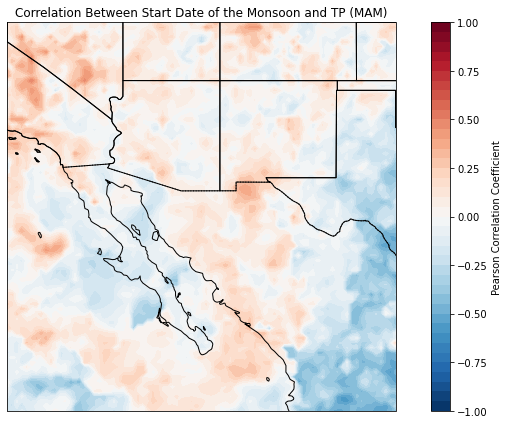

Plot already exists for: corr_sd_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


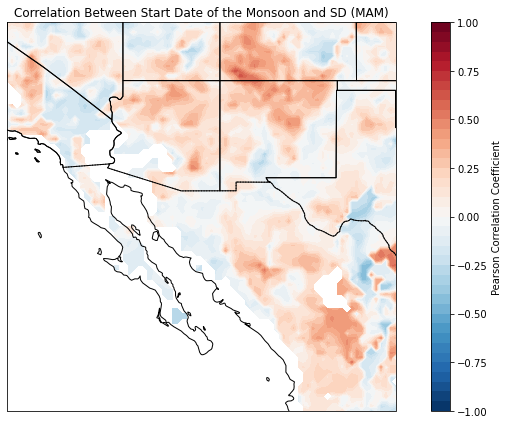

Plot already exists for: corr_msl_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


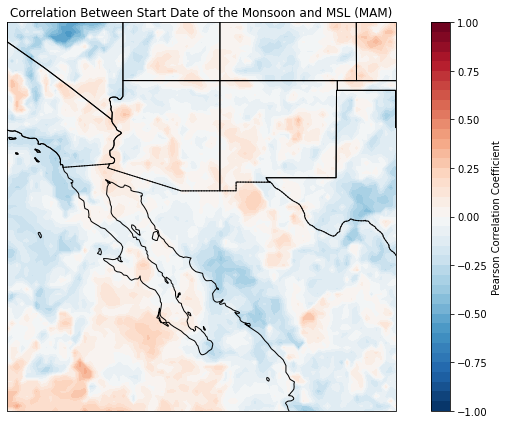

Plot already exists for: corr_tcc_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


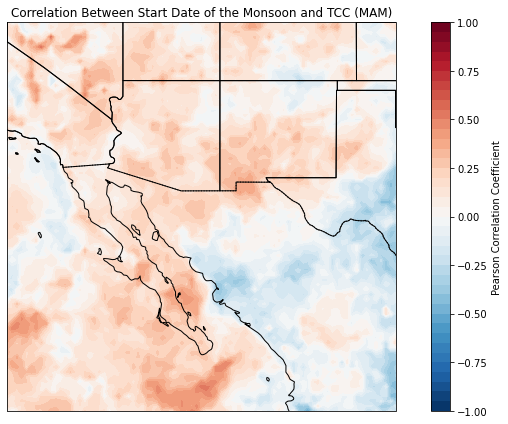

Plot already exists for: corr_stl1_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


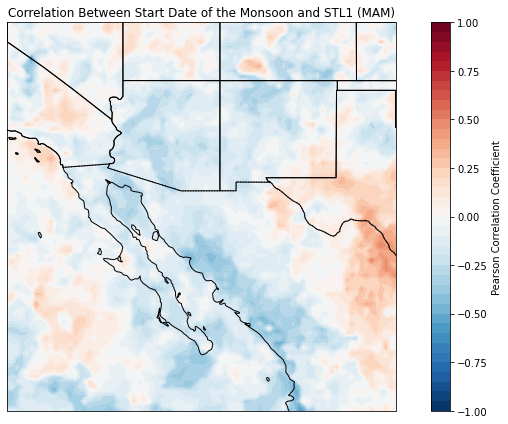

Plot already exists for: corr_stl2_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


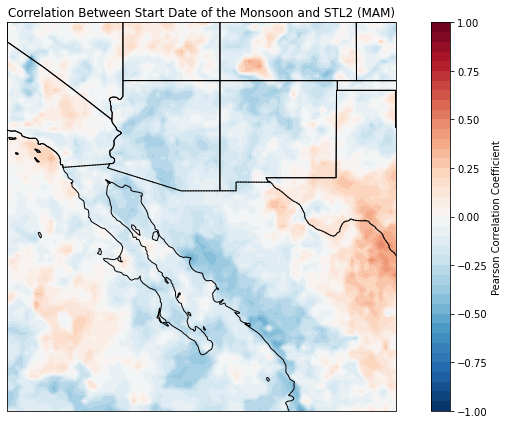

Plot already exists for: corr_stl3_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


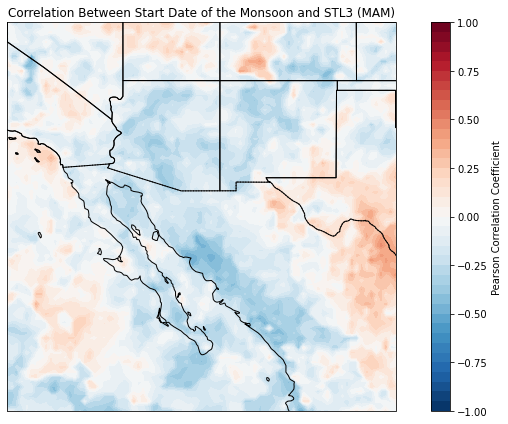

Plot already exists for: corr_stl4_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


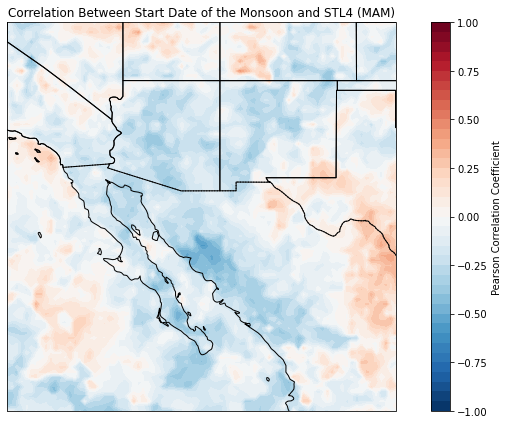

Plot already exists for: corr_swvl1_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


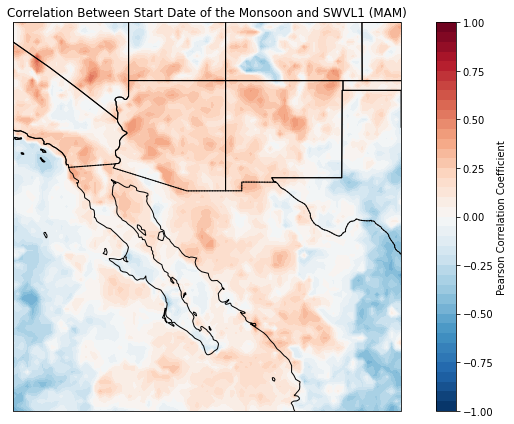

Plot already exists for: corr_swvl2_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


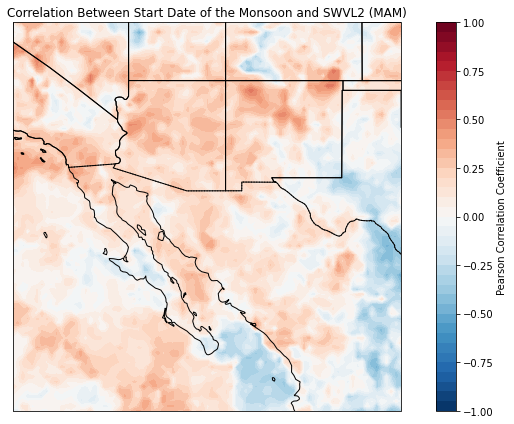

Plot already exists for: corr_swvl3_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


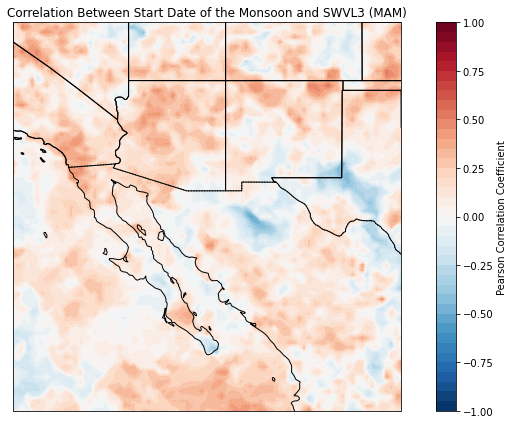

Plot already exists for: corr_swvl4_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


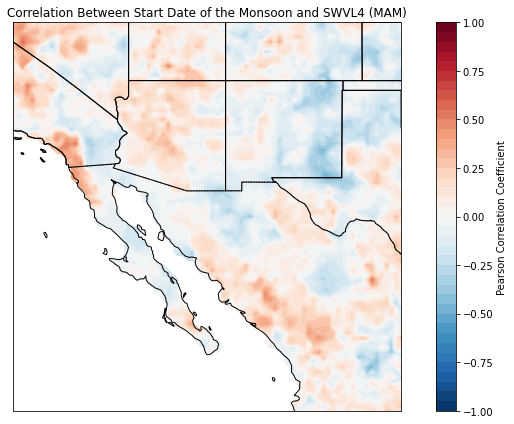

Plot already exists for: corr_2t_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


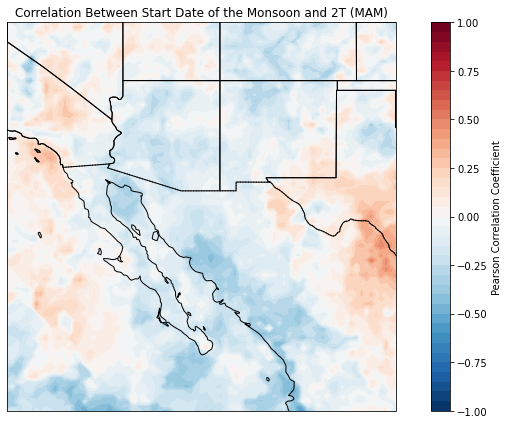

Plot already exists for: corr_2d_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


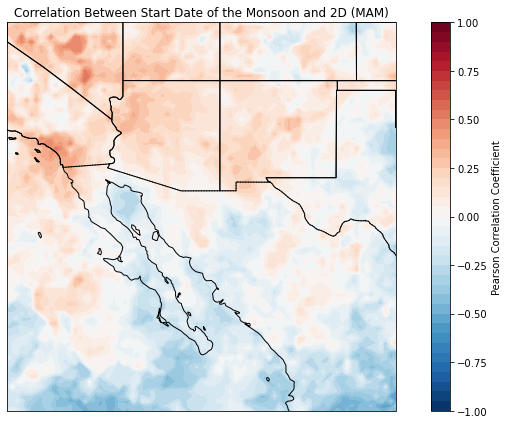

Plot already exists for: corr_ishf_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


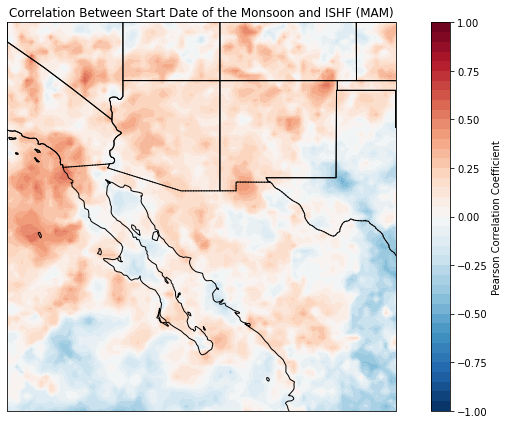

Plot already exists for: corr_ie_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


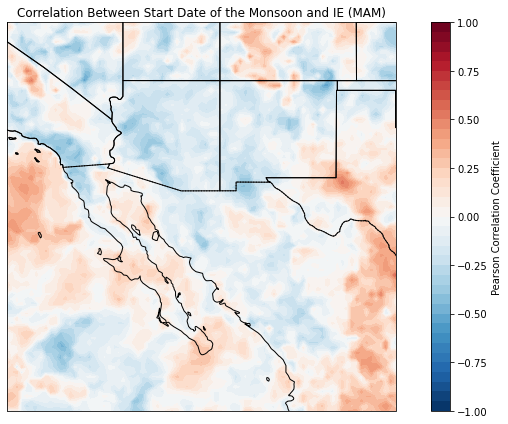

Plot already exists for: corr_sshf_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


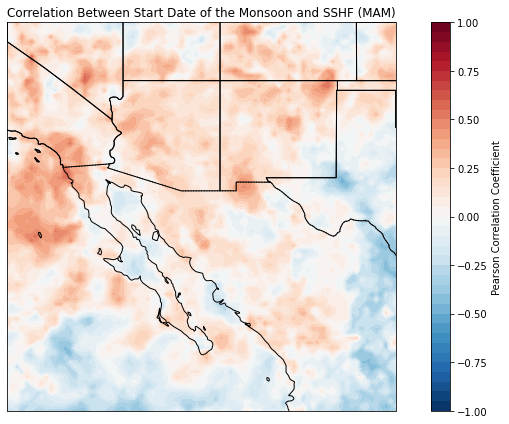

Plot already exists for: corr_slhf_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


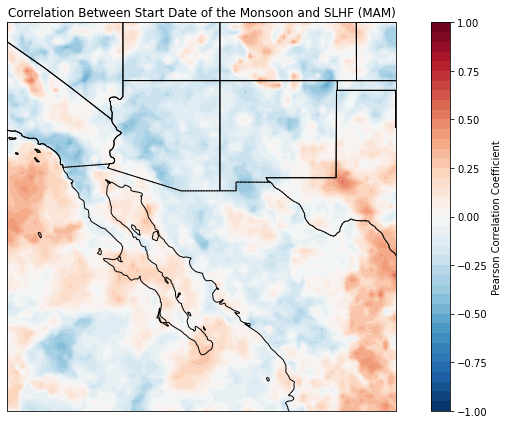

Plot already exists for: corr_ssr_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


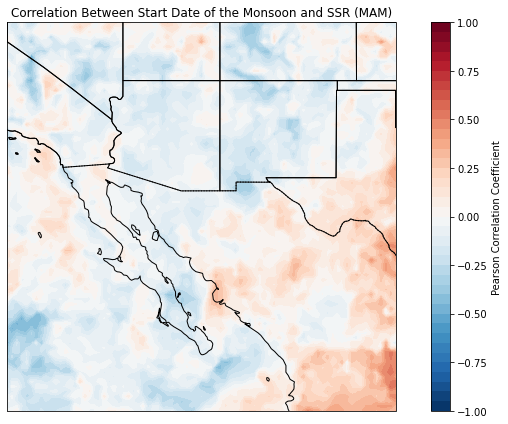

Plot already exists for: corr_str_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


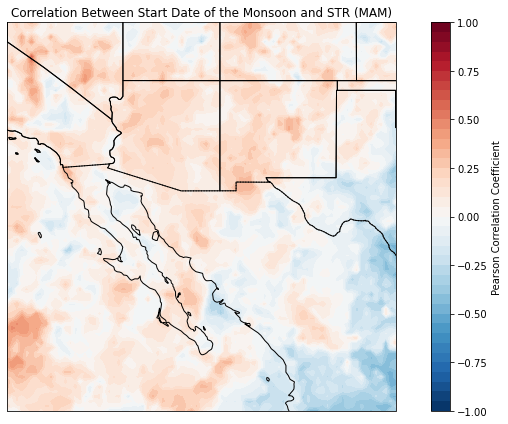

Plot already exists for: corr_sro_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


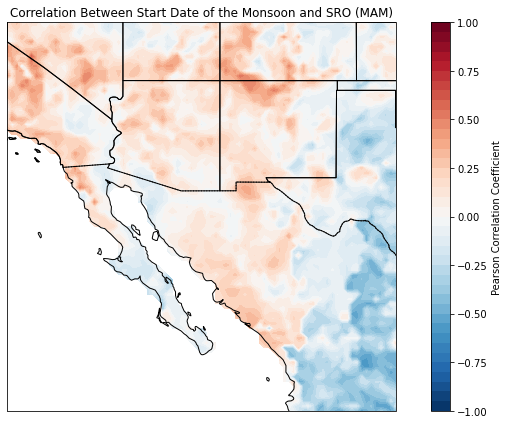

Plot already exists for: corr_sf_onset_MAM_dsw

Set overwrite_flag = True to overwrite

Skipping . . .


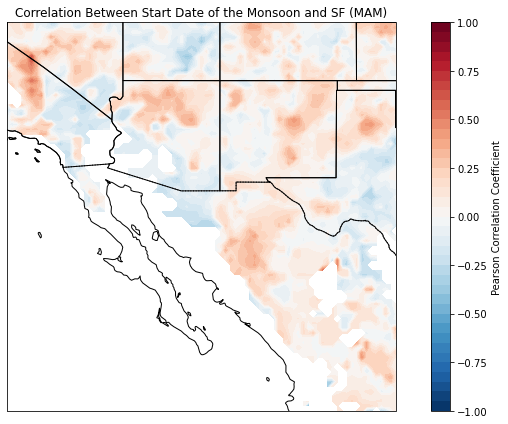

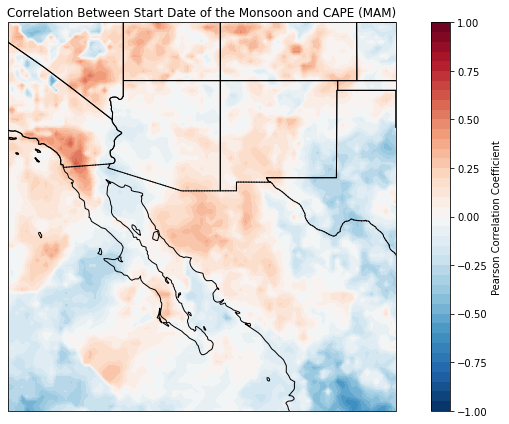

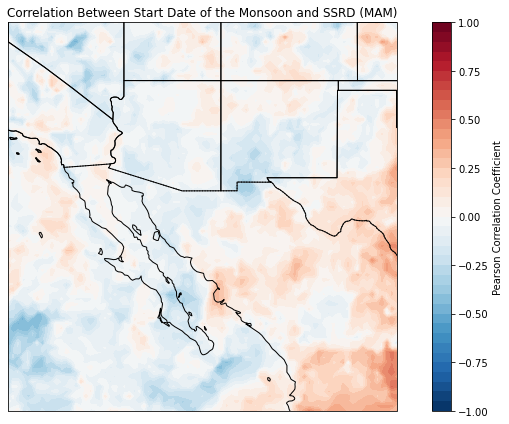

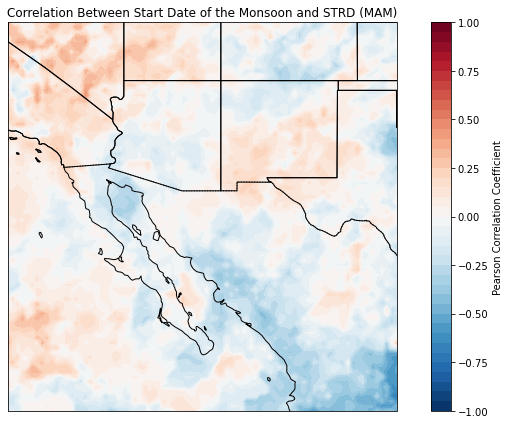

In [5]:
# plot correlations with vars and dsw onset
for var in var_list:
    plot_onset_correlation(var=var, months=345)

Plot already exists for: corr_tp_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


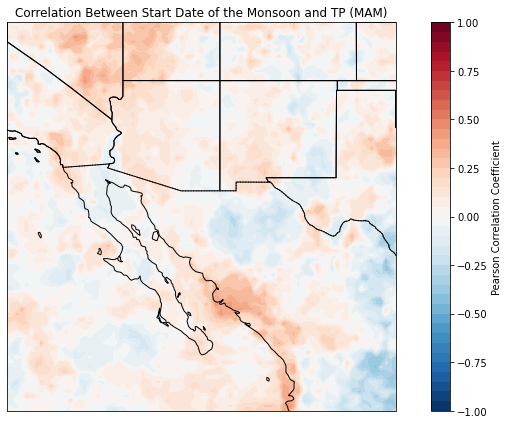

Plot already exists for: corr_sd_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


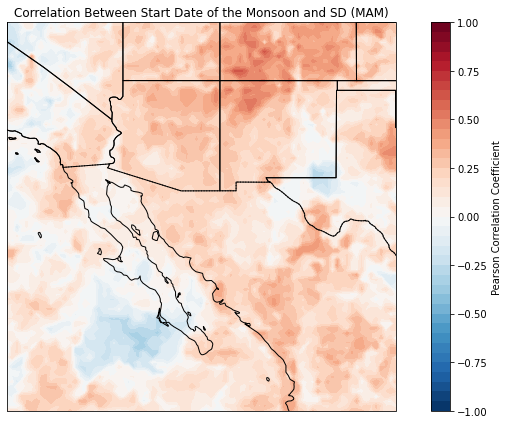

Plot already exists for: corr_msl_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


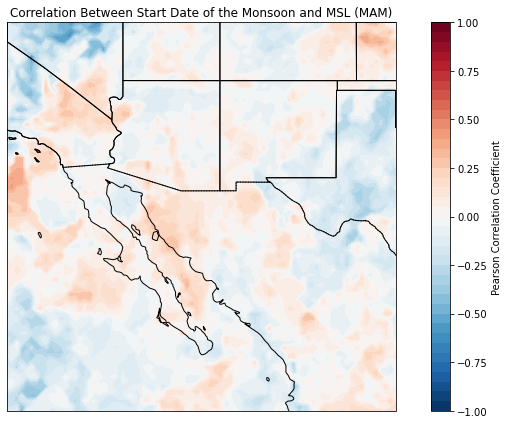

Plot already exists for: corr_tcc_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


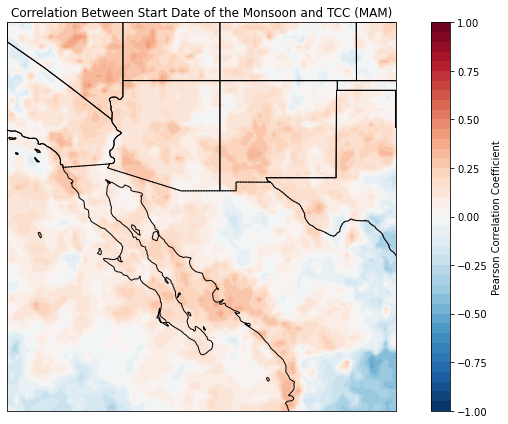

Plot already exists for: corr_stl1_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


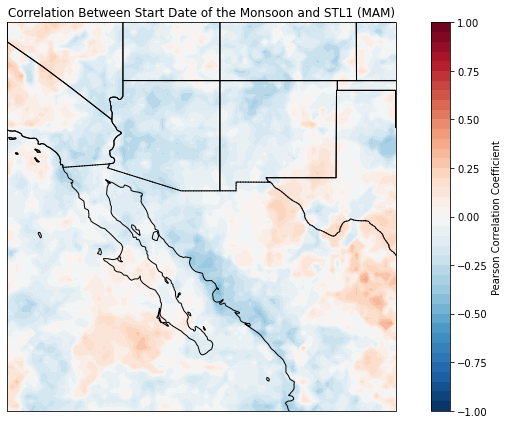

Plot already exists for: corr_stl2_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


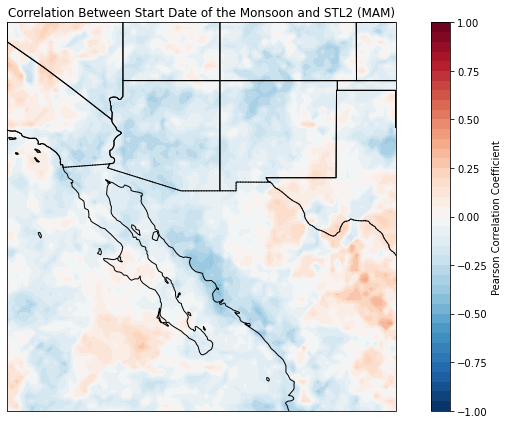

Plot already exists for: corr_stl3_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


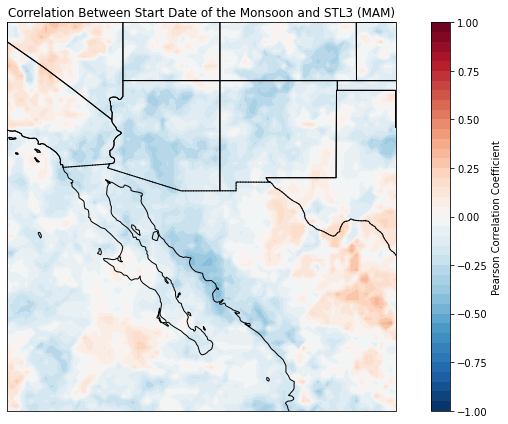

Plot already exists for: corr_stl4_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


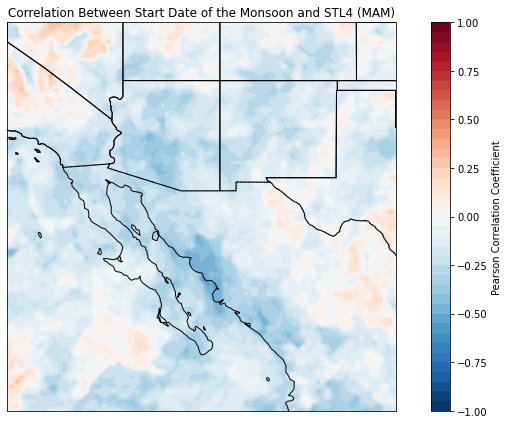

Plot already exists for: corr_swvl1_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


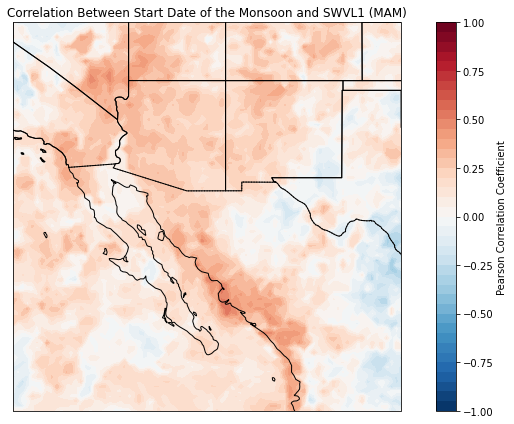

Plot already exists for: corr_swvl2_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


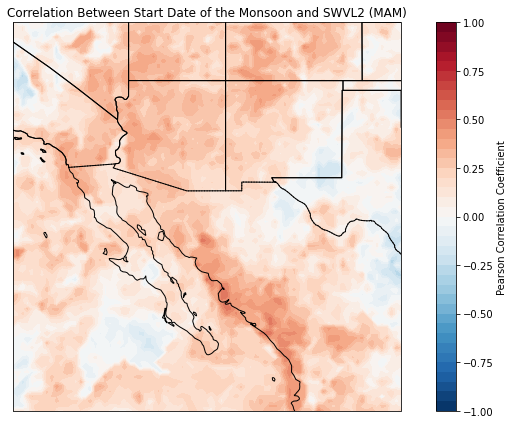

Plot already exists for: corr_swvl3_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


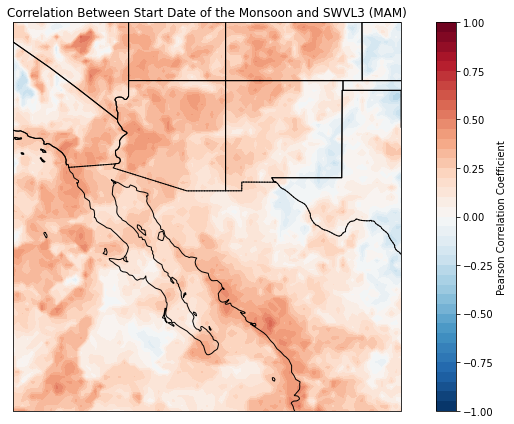

Plot already exists for: corr_swvl4_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


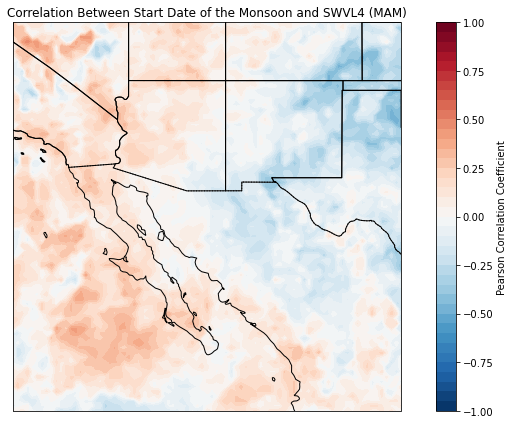

Plot already exists for: corr_2t_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


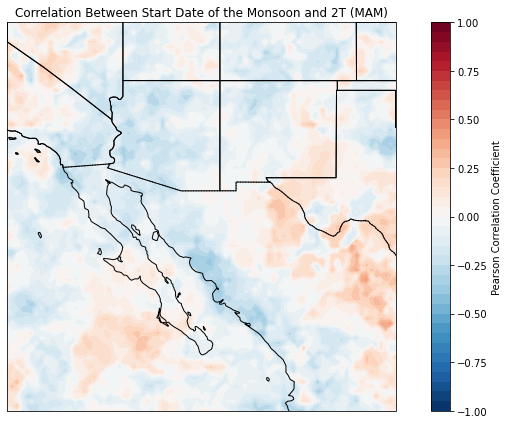

Plot already exists for: corr_2d_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


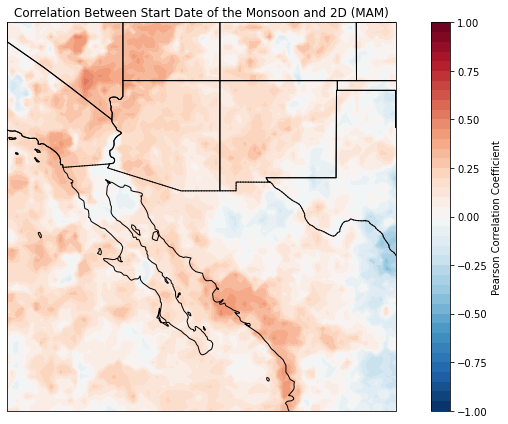

Plot already exists for: corr_ishf_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


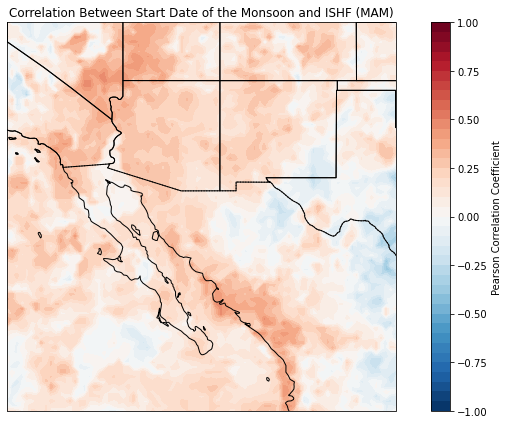

Plot already exists for: corr_ie_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


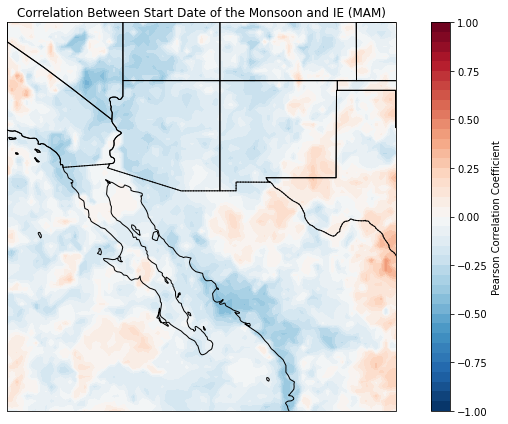

Plot already exists for: corr_sshf_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


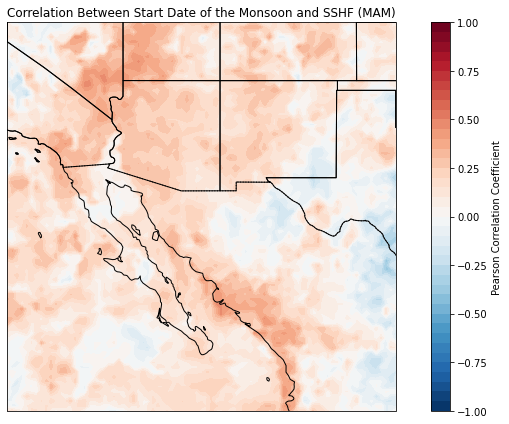

Plot already exists for: corr_slhf_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


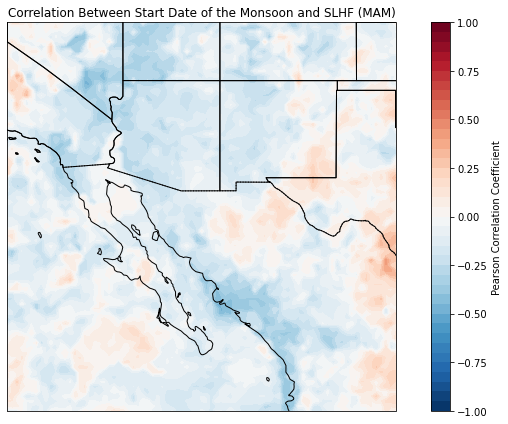

Plot already exists for: corr_ssr_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


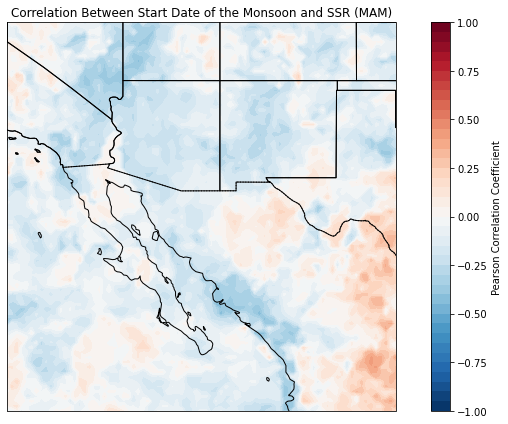

Plot already exists for: corr_str_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


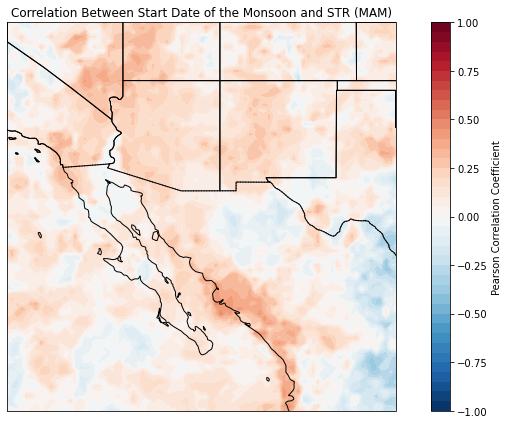

Plot already exists for: corr_sro_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


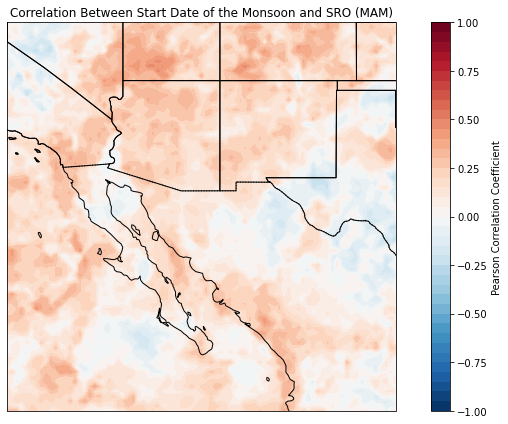

Plot already exists for: corr_sf_onset_MAM_cp

Set overwrite_flag = True to overwrite

Skipping . . .


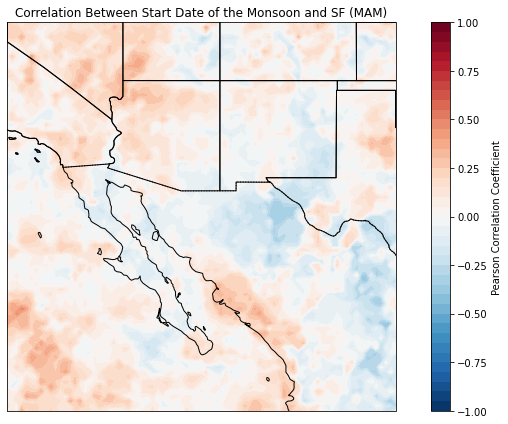

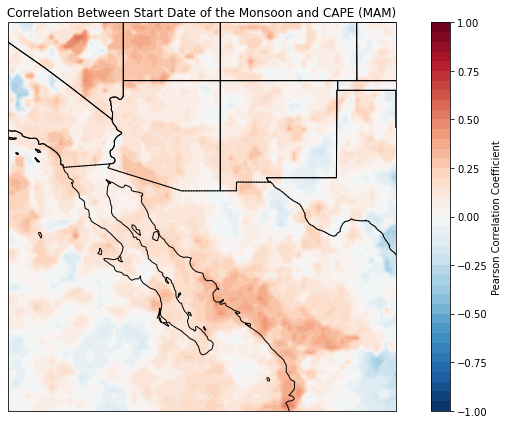

OSError: no files to open

In [6]:
# plot correlations with cp vars and dsw onset
for var in var_list:
    plot_onset_correlation(var=var, months=345, cp_flag=True)